In [1]:
import numpy as np
import os
#from cellpose import utils, io, models
#from cellpose import plot
import matplotlib.pyplot as plt
from PIL import Image
from scipy.optimize import curve_fit
from scipy.integrate import quad
from skimage.io import imread
#import imgaug.augmenters as iaa
import cv2
import json
from scipy.spatial import KDTree
import random
from scipy.special import gamma
import seaborn as sns
import pandas as pd

In [2]:
'''
def make_square(image):
    """
    Takes an image and returns a centered square cropped version.
    If the image is already square, returns the original image.
    """
    h, w = image.shape[:2]
    if h == w:
        return image

    min_dim = min(h, w)
    start_x = (w - min_dim) // 2
    start_y = (h - min_dim) // 2
    end_x = start_x + min_dim
    end_y = start_y + min_dim
    return image[start_y:end_y, start_x:end_x]

def make_square(image):
    """
    Takes an image and returns a centered square cropped version where
    the side length is the nearest lower power of two.
    If the image is square and its dimensions are already a power of two,
    it returns the original image.
    """
    h, w = image.shape[:2]
    if h == w and (h & (h - 1)) == 0:
        return image
    
    # Find the smaller of the two dimensions
    min_dim = min(h, w)
    
    # Find the nearest smaller power of two
    nearest_power_of_two = 2 ** int(np.log2(min_dim))
    
    # Calculate the start and end cropping coordinates
    start_x = (w - nearest_power_of_two) // 2
    start_y = (h - nearest_power_of_two) // 2
    end_x = start_x + nearest_power_of_two
    end_y = start_y + nearest_power_of_two

    return image[start_y:end_y, start_x:end_x]
    
'''
def make_square(image):
    """
    Takes an image and pads it to be square, using a black background.
    """
    h, w = image.shape[:2]
    
    # Create padding instructions for grayscale (2D) and color (3D) images
    if len(image.shape) == 2:  # Grayscale image
        padding_dims = ((0, 0), (0, 0))
    else:  # RGB or similar 3D image
        padding_dims = ((0, 0), (0, 0), (0, 0))

    # If the image's height is less than its width
    if h < w:
        padding_top = (w - h) // 2
        padding_bottom = w - h - padding_top
        padding_dims = ((padding_top, padding_bottom), (0, 0))
    # Else, pad horizontally
    elif h > w:
        padding_left = (h - w) // 2
        padding_right = h - w - padding_left
        padding_dims = ((0, 0), (padding_left, padding_right))
        
        
    padded_image = np.pad(image, padding_dims, mode='constant', constant_values=0)
    
    # If the padded image is smaller than 512x512, resize it to 256x256
    #h_padded, w_padded = padded_image.shape[:2]
    #if h_padded < 512 and w_padded < 512:
    #    padded_image = cv2.resize(padded_image, (256, 256))
    
    return padded_image


# Test the function
# image = np.random.rand(500, 412, 3)  # Example non-square image
# result = crop_to_power_of_two(image)

def rayleigh(x, sigma, A):
    """Rayleigh distribution function scaled by amplitude A"""
    return A * (x / sigma**2) * np.exp(-x**2 / (2*sigma**2))


def gamma_distribution(x, k, theta, A):
    """Gamma distribution function scaled by amplitude A"""
    return A * (x**(k-1) * np.exp(-x/theta)) / (theta**k * gamma(k))


def resize_to_512_if_needed(image):
    """
    Resizes a squared image to 512x512 if its resolution is bigger than 512x512.
    
    Args:
        image (np.ndarray): The input image.

    Returns:
        np.ndarray: The possibly resized image.
    """
    H, W = image.shape[:2]
    if H > 512 and W > 512:
        return cv2.resize(image, (512, 512), interpolation=cv2.INTER_LANCZOS4)
    if H<512 and W<512:
        return cv2.resize(image, (256, 256), interpolation=cv2.INTER_LANCZOS4)
    else:
        return image



def ctc_2_CNet_track(path_X,suff_X,path_Y,suff_Y,start_ind,mu,shape,half=True,prompt='hela_ctc',alt=0,save_dir_org='/home/mo/Desktop/IWR/Cell_GT_Proj/CNet_cells_track/',test=False,step=1,specific_i=None,mito_d=4):
    
    #data=[]
    test_entries = []
    train_entries = []
    l_ind=start_ind
    if specific_i is not None:
        end=1
    else:
        end=999
        
    save_dir=save_dir_org
    save_dir_test=save_dir.replace('train', 'test')
    
    if not os.path.exists(save_dir + '/target/'):
        os.makedirs(save_dir + '/target/')
        
    if not os.path.exists(save_dir + '/source/'):
        os.makedirs(save_dir + '/source/')
        
    if not os.path.exists(save_dir_test + '/target/'):
        os.makedirs(save_dir_test + '/target/')
        
    if not os.path.exists(save_dir_test + '/source/'):
        os.makedirs(save_dir_test + '/source/')
        
    for i in range(end):
        test=False
        save_dir=save_dir_org
        
        
        try:
            ind=i+step
            path_r_X0 = path_X +'/' +suff_X + '{:03d}'.format(ind) + '.tif'
            path_r_Y0 = path_Y+'/TRA/'+suff_Y+'{:03d}'.format(ind)+'.tif'
            path_r_X1 = path_X +'/' +suff_X + '{:03d}'.format(i) + '.tif'
            path_r_Y1 = path_Y+'/TRA/'+suff_Y+'{:03d}'.format(i)+'.tif'

            if specific_i is not None:

                path_r_X0 = path_X + suff_X + '{:03d}'.format(specific_i+1) + '.tif'
                path_r_Y0 = path_Y + suff_Y + '{:03d}'.format(specific_i+1) + '.tif'
                path_r_X1 = path_X + suff_X + '{:03d}'.format(specific_i) + '.tif'
                path_r_Y1 = path_Y + suff_Y + '{:03d}'.format(specific_i) + '.tif'





            img_r_X0 = imread(path_r_X0)
            img_r_Y0 = imread(path_r_Y0)
            img_r_X1 = imread(path_r_X1)
            img_r_Y1 = imread(path_r_Y1)

            max_X = np.max(img_r_X0)
            img_r_X0 = (img_r_X0/max_X)*255
            img_r_X1 = (img_r_X1/max_X)*255


            
            
            
            '''
            if half:
                min_side = min(shape[0], shape[1])
                half_min_side = int(min_side / 2)

                start_x = np.random.randint(0, shape[1] - half_min_side)
                end_x = start_x + half_min_side

                start_y = np.random.randint(0, shape[0] - half_min_side)
                end_y = start_y + half_min_side
            '''
            
            if half:
                #print('shape',shape)
                start_x = np.random.randint(0, int(shape[1]/2))
                end_x = start_x + int(shape[1]/2)
                start_y = np.random.randint(0, int(shape[0]/2))
                end_y = start_y + int(shape[0]/2)
 
                img_r_X0 = img_r_X0[start_y:end_y, start_x:end_x]
                img_r_X1 = img_r_X1[start_y:end_y, start_x:end_x]
                img_r_Y0 = img_r_Y0[start_y:end_y, start_x:end_x]
                img_r_Y1 = img_r_Y1[start_y:end_y, start_x:end_x]
            
                
                img_r_X0=make_square(img_r_X0)
                img_r_X1=make_square(img_r_X1)
                img_r_Y0=make_square(img_r_Y0)
                img_r_Y1=make_square(img_r_Y1)
                
            else:
                img_r_X0=make_square(img_r_X0)
                img_r_X1=make_square(img_r_X1)
                img_r_Y0=make_square(img_r_Y0)
                img_r_Y1=make_square(img_r_Y1)




            probability = 0.1  # 10% probability

            # Generate a random number between 0 and 1
            random_number = random.random()

            # Check if the random number is less than the desired probability
            if random_number < probability:
                test=True
                #print('is_True',)

            if test:
                save_dir=save_dir_test

            with open(path_Y+'/TRA/'+'man_track.txt', 'r') as file:
                lineage = file.readlines()


            img_r_Y1=connect_matching_dots(img_r_Y0,img_r_Y1,path_Y+'/TRA/',ind,img_r_X0,i+step,mu,lineage=lineage,d=mito_d)
            
            
            number_of_images = count_images_in_directory(save_dir + '/target/')
            if (save_dir == save_dir_test and number_of_images < 20) or save_dir != save_dir_test:
            
                output_path_X0 = save_dir + '/target/' + str(start_ind + i + 1)+'_'+ str(i)+ '.png'
                output_path_Y0 = save_dir + '/source/' + str(start_ind + i + 1) +'_'+ str(i)+ '.png'
                output_path_X1 = save_dir + '/target/' + str(start_ind + i) + '_'+ str(i)+'.png'
                output_path_Y1 = save_dir + '/source/' + str(start_ind + i) + '_'+ str(i)+'.png'


                img_r_Y1 = (img_r_Y1).astype(np.uint8)


                img_r_X1,img_r_Y1=augment_images(img_r_X1, img_r_Y1, alt)
                
                            
                img_r_Y1=resize_to_512_if_needed(img_r_Y1)
                img_r_X1=resize_to_512_if_needed(img_r_X1)

                #cv2.imwrite(output_path_Y0, combined_imag0)
                cv2.imwrite(output_path_Y1, img_r_Y1)
                #cv2.imwrite(output_path_X0, img_r_X0)
                cv2.imwrite(output_path_X1, img_r_X1)
                l_ind = l_ind + 1
                #print('out',output_path_X1)
                #print(stop)




                entry = {
                "source": 'source/' + str(start_ind + i) + '_'+ str(i)+'.png',
                "target": 'target/' + str(start_ind + i) + '_'+ str(i)+'.png',
                "prompt": prompt
                }

                # Append the entry to the data list
                #data.append(entry)

                if test:
                    test_entries.append(entry)

                else:
                    train_entries.append(entry)




                        # Write the data list as JSON to a file



        except Exception as e:
            if not str(e).startswith("[Errno 2]"):
                 traceback.print_exc()
                    #print("An error occurred:", str(e))

    save_list=[save_dir,save_dir_test]    
    for h in range(2): 
        save_dir=save_list[h]
        if h==0:
            data = train_entries
        else:
            data = test_entries
    
        output_path = save_dir+"/prompt.json"    
        existing_data = []



        # Read existing data from the JSON file, if it exists
        try:
            with open(output_path, "r") as infile:
                for line in infile:
                    line = line.strip()  # Remove leading/trailing whitespaces
                    if line:
                        data_j = json.loads(line)
                        existing_data.append(data_j)
        except FileNotFoundError:
            pass

        #print('!!!!!!ex',existing_data)
        #print('!!!!!!dat',data)
        # Append new entries to the existing data
        existing_data=existing_data+data
        #print('!!!!!!ex2',existing_data)

        # Write the updated data to the JSON file
        with open(output_path, "w") as outfile:
            for entry in existing_data:
                #print('ent',entry)
                json.dump(entry, outfile)
                outfile.write('\n') 

    return l_ind



def count_images_in_directory(directory_path):
    return sum([len(files) for r, d, files in os.walk(directory_path)])


def connect_matching_dots(img1, img2, path, t, cells, frame,mu,d,test=False, deep=False, lineage=None):
    # Find unique pixel values and their counts in both images
    unique_values_1, counts_1 = np.unique(img1, return_counts=True)
    unique_values_2, counts_2 = np.unique(img2, return_counts=True)
    counts_2_dict = dict(zip(unique_values_2, counts_2))
    
    # Create an output image for dots and lines separately
    output_img_dots = np.zeros_like(img1)
    output_img_lines = np.zeros_like(img1)
    output_img_splits = np.zeros_like(img1)

    # Initialize 3-channel image with zeros
    output_img_dots = np.stack((output_img_dots,)*3, axis=-1)
    output_img_lines = np.stack((output_img_lines,)*3, axis=-1)
    output_img_splits = np.stack((np.zeros_like(img1),)*3, axis=-1)

    # Draw dots in blue
    output_img_dots[:, :, 2] = cells  
    radius = int(np.sqrt(mu / np.pi) / 4) if int(np.sqrt(mu / np.pi) / 4) > 2 else 2
    
    #rint('!!!!radius',radius)
    
    # Draw lines and circles in green
    for value in unique_values_1[unique_values_1 > 0]:
        # Find the coordinates of matching dots in both images
        coordinates_img1 = np.argwhere(img1 == value)
        coordinates_img2 = np.argwhere(img2 == value)

        if coordinates_img2.size > 0: 
            
            coord1 = np.mean(coordinates_img1, axis=0, dtype=int)
            coord2 = np.mean(coordinates_img2, axis=0, dtype=int)

            flag = check_split_timeframe(frame, value, lineage, d)

            if test:
                coord2 = test_transform(coord1, coord2)

            line_color = [55, 200, 0]
            circle_color = get_gradient_color(d, flag)

            cv2.line(output_img_lines, tuple(coord1[::-1]), tuple(coord2[::-1]), color=line_color, thickness=3)
            circle_color = [int(val) for val in circle_color]
            cv2.circle(output_img_lines, tuple(coord2[::-1]), radius, color=circle_color, thickness=-1)
            # Define the radius for this specific point
            '''
            if test:
                coord2 = test_transform(coord1, coord2)
            
            if flag==0:
                cv2.line(output_img_lines, tuple(coord1[::-1]), tuple(coord2[::-1]), color=[55, 200, 0], thickness=3)
                cv2.circle(output_img_lines, tuple(coord2[::-1]), radius, color=[0, 255, 0], thickness=-1) # Filled circle
            elif flag==1:
                cv2.line(output_img_lines, tuple(coord1[::-1]), tuple(coord2[::-1]), color=[55, 200, 0], thickness=3)
                cv2.circle(output_img_lines, tuple(coord2[::-1]), radius, color=[255, 255, 0], thickness=-1) # Filled circle
            elif flag==2:
                #print('flag2',t,frame)
                cv2.line(output_img_lines, tuple(coord1[::-1]), tuple(coord2[::-1]), color=[55, 200, 0], thickness=3)
                cv2.circle(output_img_lines, tuple(coord2[::-1]), radius, color=[170, 255, 0], thickness=-1) # Filled
            elif flag==3:
                #print('flag2',t,frame)
                cv2.line(output_img_lines, tuple(coord1[::-1]), tuple(coord2[::-1]), color=[55, 200, 0], thickness=3)
                cv2.circle(output_img_lines, tuple(coord2[::-1]), radius, color=[85, 255, 0], thickness=-1) # Filled 
            elif flag==-1:
                #print('flag2',t,frame)
                cv2.line(output_img_lines, tuple(coord1[::-1]), tuple(coord2[::-1]), color=[55, 200, 0], thickness=3)
                cv2.circle(output_img_lines, tuple(coord2[::-1]), radius, color=[255, 50, 0], thickness=-1) # Filled 
                
            elif flag==-2:
                #print('flag2',t,frame)
                cv2.line(output_img_lines, tuple(coord1[::-1]), tuple(coord2[::-1]), color=[55, 200, 0], thickness=3)
                cv2.circle(output_img_lines, tuple(coord2[::-1]), radius, color=[255, 100,0],thickness=-1) # Filled
                
            elif flag==-3:
                #print('flag2',t,frame)
                cv2.line(output_img_lines, tuple(coord1[::-1]), tuple(coord2[::-1]), color=[55, 200, 0], thickness=3)
                cv2.circle(output_img_lines, tuple(coord2[::-1]), radius, color=[255, 150, 0], thickness=-1) # Filled 
            elif flag==-4:
                #print('flag2',t,frame)
                cv2.line(output_img_lines, tuple(coord1[::-1]), tuple(coord2[::-1]), color=[55, 200, 0], thickness=3)
                cv2.circle(output_img_lines, tuple(coord2[::-1]), radius, color=[255, 200, 0], thickness=-1) # Filled 
                
           '''
        else:
            cs = check_split(path, t, value)
                
            if cs[0]:
                coordinates_img1 = np.argwhere(img1 == value)
                coordinates_img2 = np.argwhere(img2 == cs[1])
                if coordinates_img2.size > 0: 
                    coord1 = np.mean(coordinates_img1, axis=0, dtype=int)
                    coord2 = np.mean(coordinates_img2, axis=0, dtype=int)
                    cv2.line(output_img_splits, tuple(coord1[::-1]), tuple(coord2[::-1]), color=[200, 55, 0], thickness=3)
                    cv2.circle(output_img_splits, tuple(coord2[::-1]), radius, color=[255, 0, 0], thickness=-1)  # Filled circle

    # Stack images along the channel dimension: Red for splits, Green for lines, Blue for dots
    output_img = output_img_dots + output_img_lines + output_img_splits
    return output_img


def check_split(path,t,value):
    data = np.loadtxt(path+'man_track.txt')

    # Split the data into columns
    start = data[:, 1]
    ide = data[:, 0][start==t]
    
    end = data[:, 2][start==t]
    parent = data[:, 3][start==t]
    
    try:
        par = parent[ide==value]
        print('p_t_pa_v',par,t,path,value)
        
        if len(ide[parent==par])==2:
            print('ide',ide[parent==par])
            return True,par[0]
        else:
            return False,0
        
    except:
        return False,0
    
def parse_lineage_data(data):
    """
    Convert the given lineage data to a list of dictionaries.
    """
    result = []
    for line in data:
        L, B, E, P = map(int, line.split())
        result.append({
            'label': L,
            'frame_start': B,
            'frame_end': E,
            'parent': P
        })
    return result

'''
def check_split_timeframe(t, cell_id, lineage_data,pos=False):
    """
    Check the time difference for the given cell_id and timeframe t.
    """
    parsed_data = parse_lineage_data(lineage_data)

    # Finding the cell with the given cell_id
    current_cell = None
    for cell in parsed_data:
        if cell['label'] == cell_id:
            current_cell = cell
            break
    else:
        print('Cell not found',cell_id)
        return 0

    # If the cell has a parent (indicating it has emerged from a merge)
    if current_cell['parent'] != 0:
        time_difference_from_merge = t - current_cell['frame_start']
        if time_difference_from_merge == 1:
            return -1
        elif time_difference_from_merge == 2:
            return -2
        elif time_difference_from_merge == 3:
            return -3
        elif time_difference_from_merge == 4:
            return -4
        elif time_difference_from_merge == 0 and pos:
            return 99

    # Check if the cell will merge soon with another cell
    for cell in parsed_data:
        if cell['parent'] == current_cell['label']:
            merge_point = cell['frame_start']
            time_difference_to_next_merge = merge_point - t

            if time_difference_to_next_merge == 1:
                return 1
            elif time_difference_to_next_merge == 2:
                return 2
            elif time_difference_to_next_merge == 3:
                return 3

    return 0

'''

# Reading the file
def get_gradient_color(d, flag):
    base_color = [0, 255, 0]  # Pure green as base color

    if flag == 0:
        return base_color
    elif flag > 0:
        return [255-((flag-1)*(255/(d-1))),255,0]
    else:  # flag < 0
        return [255,50+((abs(flag)-1)*(150/(d-1))),0]
    
'''    
def get_gradient_color(d, value):
    base_color = np.array([55, 200, 0]) 
    if value > 0:
        gradient_color = np.array([0, 255, 0]) - base_color
    else:
        gradient_color = np.array([255, 50, 0]) - base_color
    step = gradient_color/d
    return list((base_color + abs(value) * step).astype(int))
'''

def check_split_timeframe(t, cell_id, lineage_data, d, pos=False):
    #print('mito_d',d)
    parsed_data = parse_lineage_data(lineage_data)
    
    current_cell = next((cell for cell in parsed_data if cell['label'] == cell_id), None)
    if not current_cell:
        print('Cell not found', cell_id)
        return 0
    
    if current_cell['parent'] != 0:
        time_difference_from_merge = t - current_cell['frame_start']
        if 0 < time_difference_from_merge <= d:
            return -time_difference_from_merge
        elif time_difference_from_merge == 0 and pos:
            return 99
    
    for cell in parsed_data:
        if cell['parent'] == current_cell['label']:
            merge_point = cell['frame_start']
            time_difference_to_next_merge = merge_point - t
            if 0 < time_difference_to_next_merge <= d:
                return time_difference_to_next_merge
    return 0


def crop_half(image):
    """
    Takes an image and crops a section from it which has half the width and half the height of the original image.
    """
    h, w = image.shape[:2]

    # Calculate half dimensions
    half_width = w // 2
    half_height = h // 2

    # Get random start points within the range from which we can crop half the dimensions
    start_x = np.random.randint(0, w - half_width)
    end_x = start_x + half_width

    start_y = np.random.randint(0, h - half_height)
    end_y = start_y + half_height

    # Crop the random region from the image
    cropped_image = image[start_y:end_y, start_x:end_x]

    return cropped_image

def ctc_2_CNet(path_X,path_Y,suff_X,suff_Y,start_ind,mu,shape,half=True,prompt='hela_ctc',alt=0,save_dir='/home/mo/Desktop/IWR/Cell_GT_Proj/CNet_cells/',test=False,mito_d=4):
    
    
    end=999
    
    if test:
        save_dir=save_dir.replace('train', 'test')
        end=10
    
    if not os.path.exists(save_dir + '/target/'):
        os.makedirs(save_dir + '/target/')
        
    if not os.path.exists(save_dir + '/source/'):
        os.makedirs(save_dir + '/source/')
    
    
    data=[]
    l_ind=start_ind
    for i in range(end):
        
        try:
            path_r_X=path_X+'/'+suff_X+'{:03d}'.format(i)+'.tif'
            path_r_Y=path_Y+'/TRA/'+suff_Y+'{:03d}'.format(i)+'.tif'
            # read the tif file
            #print('p',path_r)
            #try:
            #img_r_X = tiff.imread(path_r_X)
            #img_r_Y = tiff.imread(path_r_Y)
            img_r_X = imread(path_r_X)
            img_r_Y = imread(path_r_Y)


            max_X=np.max(img_r_X)
            img_r_X = (img_r_X/max_X)*255
            #max_y=np.max(img_r_Y)
            #img_r_Y = (img_r_Y/max_y)*255
            

            if half:
                #print('shape',shape)
                start_x = np.random.randint(0, int(shape[1]/2))
                end_x = start_x + int(shape[1]/2)
                start_y = np.random.randint(0, int(shape[0]/2))
                end_y = start_y + int(shape[0]/2)
                #print(start_y,end_y, start_x,end_x)
                # Crop the random region from img_r_X
                img_r_X = img_r_X[start_y:end_y, start_x:end_x]

                # Crop the random region from img_r_Y
                img_r_Y = img_r_Y[start_y:end_y, start_x:end_x]
                
                img_r_X=make_square(img_r_X)
                img_r_Y=make_square(img_r_Y)
            else:
                img_r_X=make_square(img_r_X)
                img_r_Y=make_square(img_r_Y)
                
                
                
            '''  
            
            if half:
                
                min_side = min(shape[0], shape[1])
                half_min_side = int(min_side / 2)

                start_x = np.random.randint(0, shape[1] - half_min_side)
                end_x = start_x + half_min_side

                start_y = np.random.randint(0, shape[0] - half_min_side)
                end_y = start_y + half_min_side

                # Crop the random square region from img_r_X
                img_r_X = img_r_X[start_y:end_y, start_x:end_x]

                # Crop the random region from img_r_Y
                img_r_Y = img_r_Y[start_y:end_y, start_x:end_x]
            '''

                




            #print('both shapes',img_r_X.shape,img_r_Y.shape)
            img_r_X,img_r_Y=augment_images(img_r_X, img_r_Y,alt=alt)


            #if alt==1:
            #    cv2.imwrite(output_path_Y_c, img_r_Y)
            with open(path_Y+'/TRA/'+'man_track.txt', 'r') as file:
                lineage = file.readlines()


            img_r_Y,pos_list = source2CNet(img_r_Y, mu,i,lineage,mito_d,test=test)
            
            if test:
                file_path = os.path.join(save_dir, 'numbers.txt')
                if not os.path.exists(file_path):
                    with open(file_path, 'w') as f:
                        f.write("image\tnumber of cells\n")

                        # Determine number of cells
                        if pos_list is not None and len(pos_list) > 0:
                            num_cells = len(pos_list)
                        else:
                            num_cells = 0

                        f.write(f"{start_ind+i}\t{num_cells}\n")
                else:
                    with open(file_path, 'a') as f:
                        # Determine number of cells
                        if pos_list is not None and len(pos_list) > 0:
                            num_cells = len(pos_list)
                        else:
                            num_cells = 0

                        f.write(f"{start_ind+i}\t{num_cells}\n")

                #print('pos',pos_list,len(pos_list))

            #print('source worked')

            # Specify the output file path





            output_path_X = save_dir+'/target/'+str(start_ind+i)+'.png'
            output_path_Y = save_dir+'/source/'+str(start_ind+i)+'.png'
            #output_path_Y_c = save_dir+'source/'+str(start_ind+i)+'contr.png'

                            
            img_r_X=resize_to_512_if_needed(img_r_X)
            img_r_Y=resize_to_512_if_needed(img_r_Y)

            # Save the resized image as PNG
            cv2.imwrite(output_path_X, img_r_X)
            cv2.imwrite(output_path_Y, img_r_Y)


            entry = {
            "source": "source/" + str(start_ind+i) + ".png",
            "target": "target/" + str(start_ind+i) + ".png",
            "prompt": prompt
            }

            # Append the entry to the data list
            data.append(entry)

            l_ind=l_ind+1

                # Write the data list as JSON to a file


        
        except Exception as e:
            #print("An error occurred:", str(e))
            if not str(e).startswith("[Errno 2]"):
                traceback.print_exc()
            #
        
        
        
    output_path = save_dir + "/prompt.json"

    # Check if file exists, if not create it
    if not os.path.exists(output_path):
        open(output_path, 'a').close()   
    existing_data = []



    # Read existing data from the JSON file, if it exists
    try:
        with open(output_path, "r") as infile:
            for line in infile:
                line = line.strip()  # Remove leading/trailing whitespaces
                if line:
                    data_j = json.loads(line)
                    existing_data.append(data_j)
    except FileNotFoundError:
        pass

    #print('!!!!!!ex',existing_data)
    #print('!!!!!!dat',data)
    # Append new entries to the existing data
    existing_data=existing_data+data
    #print('!!!!!!ex2',existing_data)

    # Write the updated data to the JSON file
    with open(output_path, "w") as outfile:
        for entry in existing_data:
            #print('ent',entry)
            json.dump(entry, outfile)
            outfile.write('\n')    
        
    return l_ind





def mean_ind(indices):
    """Get the mean indices from a list of indices."""
    return np.mean(indices, axis=0)

def source2CNet(img, mu,t,lineage_data,mito_d,test=False):
    
    # Find unique values and their counts, ignoring zeros
    unique_values, unique_counts = np.unique(img, return_counts=True)
    non_zero_mask = unique_values != 0
    unique_values = unique_values[non_zero_mask]
    unique_counts = unique_counts[non_zero_mask]

    # Lists to store the mean position of each unique value and their respective counts
    '''
    pos_list = []
    count_list = []
    flag_list = []

    for value in unique_values:
        #print('value',value)
        mask = img == value
        indices = np.argwhere(mask)
        m_ind = mean_ind(indices)
        pos_list.append(m_ind)
        flag_list.append(check_split_timeframe(t, value, lineage_data,pos=True))
    
    # Initialize an output image of zeros
    image_tensor = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    if test:
        #print('pos_list_before',pos_list)
        pos_list = generate_similar_positions2(pos_list)
        flag_list = generate_flag_list(flag_list)
    
    # Determine the radius for the painted dots
    radius = int(np.sqrt(mu / np.pi) / 4) if int(np.sqrt(mu / np.pi) / 4) > 2 else 2
    #print('!!!!radius',radius)
    # Iterate over the mean positions and draw the dots
    for position, flag in zip(pos_list, flag_list):
        x, y = int(position[0]), int(position[1])
        if flag!=0:
            print('!!flag',flag)
        # Use the flag to determine the color to draw
        if flag == 0:
            color = [0, 255, 0]
        elif flag == 1:
            color = [255, 255, 0]
        elif flag == 2:
            color = [170, 255, 0]
        elif flag == 3:
            color = [85, 255, 0]
        elif flag == -1:
            color = [255, 50, 0]
        elif flag == -2:
            color = [255, 100, 0]
        elif flag == -3:
            color = [255, 150, 0]
        elif flag == -4:
            color = [255, 200, 0]
        elif flag == 99:
            color = [255, 0, 0]
            
        else:
            # Default color in case of unexpected flag value
            color = [255, 255, 255]

        cv2.circle(image_tensor, (y, x), radius, color, thickness=-1)
    '''
    pos_list = []
    flag_list = []

    for value in unique_values:
        mask = img == value
        indices = np.argwhere(mask)
        m_ind = mean_ind(indices)
        pos_list.append(m_ind)
        flag_list.append(check_split_timeframe(t, value, lineage_data, mito_d, pos=True))

    # Initialize an output image of zeros
    image_tensor = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    if test:
        pos_list = generate_similar_positions2(pos_list)
        flag_list = generate_flag_list(flag_list)

    # Determine the radius for the painted dots
    radius = int(np.sqrt(mu / np.pi) / 4) if int(np.sqrt(mu / np.pi) / 4) > 2 else 2

    # Iterate over the mean positions and draw the dots
    for position, flag in zip(pos_list, flag_list):
        x, y = int(position[0]), int(position[1])
        color = get_color(flag, mito_d)
        #print('col',color,'flag',flag)
        #color=[55, 200, 0]#[255, 255, 255]
        color = [int(val) for val in color]
        #print('col2',color)
        cv2.circle(image_tensor, (y, x), radius, color, -1)  # Filled circle
    return image_tensor, pos_list

def get_color(flag, d):
    gradient_color = get_gradient_color(d, flag)

    # Handle the special case where flag is 99
    if flag == 99:
        gradient_color = [255, 0, 0]

    return gradient_color  # Return the color as a list

def generate_similar_positions2(positions):
    # Calculate pairwise distances
    positions = np.array(positions)
    try:
        pairwise_distances = np.linalg.norm(positions[:, None] - positions, axis=2)
    except:
        return positions

    # Get the minimum distance from the pairwise_distances
    min_distance = np.min(pairwise_distances + np.eye(pairwise_distances.shape[0]) * np.max(pairwise_distances))

    # Create an empty list for new positions
    new_positions = []

    # Initial random position
    new_positions.append(np.random.uniform(low=positions.min(axis=0), high=positions.max(axis=0)))

    # Maximal number of attempts to generate a point that keeps minimal distance
    max_attempts = 1000
    attempts = 0

    while len(new_positions) < len(positions):
        if attempts > max_attempts:
            print("Cannot generate desired number of positions with the current minimal distance.")
            break

        # Sample random point
        random_point = np.random.uniform(low=positions.min(axis=0), high=positions.max(axis=0))

        # Construct KDTree
        tree = KDTree(new_positions)

        # Get the distances and indices of the closest points to the random_point
        distances, indices = tree.query(random_point, k=1)

        # Check if the minimum distance condition holds
        if distances >= min_distance:
            new_positions.append(random_point.tolist())
        else:
            attempts += 1

    # Convert list to numpy array
    if len(new_positions) > 1 and random.random() < 0.70:
        n = np.random.randint(1, len(new_positions))
        new_positions = np.array(new_positions[0:n])

        
    else:
        new_positions = np.array(new_positions)
        

    return new_positions

def generate_flag_list(input_list):
    # Define probabilities and values
    probabilities = [0.8, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
    values = [0, 1, 2, 3, -1, -2, -3, -4, 99]

    # Generate the new list
    new_list = [random.choices(values, probabilities)[0] for _ in input_list]

    return new_list

def list_target_directories(path):
    # A set of names we are looking for
    target_names = {f"{i:02}" for i in range(1, 100)} # assuming 01 to 99 as the possible names

    # List to store the directories found
    found_dirs = []

    # Walk through the root directory
    for dirpath, dirnames, filenames in os.walk(path):
        for dirname in dirnames:
            if dirname in target_names:
                found_dirs.append(os.path.join(dirpath, dirname))
    
    return found_dirs

def cellpose_segmentation(path, diameter=None):
    model = models.Cellpose(gpu=False, model_type='cyto2')
    chan = [0,0]
    directories = list_target_directories(path)
    print(directories)
    
    file_counter = 0
    
    for directory in directories:
        # Get a list of all tif files in the directory
        files = [f for f in os.listdir(directory) if f.endswith('.tif') or f.endswith('.TIF')]

        for f in files:
            # Break out of the loop if 10 files have already been processed
            if file_counter >= 10:
                break

            # Create output filename
            output_filename = f.replace('.tif', '_cp_masks.png').replace('.TIF', '_cp_masks.png')
            output_filepath = os.path.join(directory + '_CP', output_filename)
            print('out', output_filepath)
            
            # Check if the output file already exists. If it does, skip computation and saving
            if os.path.exists(output_filepath):
                print(f"{output_filename} already exists. Skipping...")
                continue

            print(f)
            img = io.imread(directory + '/' + f)
            masks, flows, styles, diams = model.eval(img, diameter=diameter, channels=chan)

            # Save results so you can load in gui
            io.masks_flows_to_seg(img, masks, flows, diams, f, chan)
            unique_values, unique_counts = np.unique(masks, return_counts=True)
            print(masks, masks.shape, unique_values, len(unique_values) - 1)

            # Save results as png
            io.save_to_png(img, masks, flows, directory + '_CP/' + f)
            fig = plt.figure(figsize=(12,5))
            plot.show_segmentation(fig, img, masks, flows[0], channels=chan)
            plt.tight_layout()
            plt.show()

            # Increment the counter
            file_counter += 1

    
def generate_CTC_datasets(path,name,save_dir,d):
    #cellpose_segmentation(path,diameter=diameter)
    mu,sig,b,shape=process_images_2(path)
    #print(stop)
    generate_XY_pairs(path,mu,sig,shape,name, save_dir,d)
    

def process_images(root_path):
    all_pixel_counts = []
    all_displacements = []

    # For area calculation
    for dirpath, dirnames, filenames in os.walk(root_path):
        if os.path.basename(dirpath).endswith('_CP') and os.path.basename(dirpath)[:2].isdigit():
            for file in filenames:
                if file.endswith('.png'):
                    img_path = os.path.join(dirpath, file)
                    img = np.array(Image.open(img_path))
                    unique_values, counts = np.unique(img, return_counts=True)
                    all_pixel_counts.extend(counts[unique_values != 0])

    first_image_shape = None
    
    for dirpath, dirnames, filenames in os.walk(root_path):
        if (os.path.basename(dirpath) == 'TRA' and 
            os.path.dirname(dirpath).endswith('_GT') and 
            os.path.basename(os.path.dirname(dirpath))[:2].isdigit()):

            filenames = sorted([f for f in filenames if f.startswith('man_track') and f.endswith('.tif')])
            print('filenames',filenames)
            for idx in range(len(filenames) - 1):
                img1_path = os.path.join(dirpath, filenames[idx])
                img2_path = os.path.join(dirpath, filenames[idx + 1])

                img1 = np.array(Image.open(img1_path))
                img2 = np.array(Image.open(img2_path))

                # Check image shapes
                if first_image_shape is None:
                    first_image_shape = img1.shape
                assert img1.shape == first_image_shape, f"Image {img1_path} has a different shape {img1.shape} than the first image shape {first_image_shape}"
                assert img2.shape == first_image_shape, f"Image {img2_path} has a different shape {img2.shape} than the first image shape {first_image_shape}"

                displacements = calculate_displacement(img1, img2)
                all_displacements.extend(displacements)

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Histogram for pixel counts
    hist_vals, bin_edges = np.histogram(all_pixel_counts, bins=75)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    popt, _ = curve_fit(one_gaussian, bin_centers, hist_vals, p0=(max(hist_vals), np.mean(all_pixel_counts), np.std(all_pixel_counts)))
    A, mu, sigma = popt
    ax[0].bar(bin_centers, hist_vals, width=np.diff(bin_edges)[0], edgecolor='black', label='Histogram Data', alpha=0.6)
    ax[0].plot(bin_centers, one_gaussian(bin_centers, *popt), 'r-', label='Fitted Gaussian')
    ax[0].set_title('Histogram of Areas Across All Images with Fitted Gaussian')
    ax[0].set_xlabel('Area (Pixel Count)')
    ax[0].set_ylabel('Number of Regions')
    ax[0].legend()

    # Histogram for displacements
    hist_vals, bin_edges = np.histogram(all_displacements, bins=50)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    #popt, _ = curve_fit(one_gaussian, bin_centers, hist_vals, p0=(max(hist_vals), np.mean(all_displacements), np.std(all_displacements)))
    ax[1].bar(bin_centers, hist_vals, width=np.diff(bin_edges)[0], edgecolor='black', label='Histogram Data', alpha=0.6)
    #popt, _ = curve_fit(half_gaussian, bin_centers, hist_vals, p0=(max(hist_vals), np.std(all_displacements)))
    initial_guess = [max(hist_vals), 2]  # A rough guess for A and n
    popt, _ = curve_fit(inverse_power_law, bin_centers[1:], hist_vals[1:], p0=initial_guess)  # We exclude the first bin since x=0 will cause division by zero
    #ax[1].plot(bin_centers, half_gaussian(bin_centers, *popt), 'r-', label='Fitted Half-Gaussian')
    A_opt, n_opt = popt
    b = int((1/0.05)**(1/n_opt))
    print('image_shapes',first_image_shape)
    print('opt',A_opt,n_opt,b,np.max(all_displacements))
    ax[1].plot(bin_centers, inverse_power_law(bin_centers, A_opt, n_opt), 'r-', label='Fitted 1/x^n curve')

    ax[1].set_title('Histogram of Displacements with Fitted Gaussian')
    ax[1].set_xlabel('Displacement (Pixels)')
    ax[1].set_ylabel('Number of Displacements')
    ax[1].legend()

    plt.tight_layout()
    plt.show()
    
    return mu,sigma,n_opt,np.max(all_displacements),first_image_shape

def process_images_2(root_path):
    all_pixel_counts = []
    all_displacements = []

    # For area calculation
    for dirpath, dirnames, filenames in os.walk(root_path):
        if (os.path.basename(dirpath) == 'SEG' and 
            os.path.dirname(dirpath).endswith('_GT') and 
            os.path.basename(os.path.dirname(dirpath))[:2].isdigit()):
            
            for file in filenames:
                if file.endswith('.tif'):
                    img_path = os.path.join(dirpath, file)
                    img = np.array(Image.open(img_path))
                    unique_values, counts = np.unique(img, return_counts=True)
                    all_pixel_counts.extend(counts[unique_values != 0])

    first_image_shape = None
    
    for dirpath, dirnames, filenames in os.walk(root_path):
        if (os.path.basename(dirpath) == 'TRA' and 
            os.path.dirname(dirpath).endswith('_GT') and 
            os.path.basename(os.path.dirname(dirpath))[:2].isdigit()):

            filenames = sorted([f for f in filenames if f.startswith('man_track') and f.endswith('.tif')])
            print('filenames',filenames)
            for idx in range(len(filenames) - 1):
                img1_path = os.path.join(dirpath, filenames[idx])
                img2_path = os.path.join(dirpath, filenames[idx + 1])

                img1 = np.array(Image.open(img1_path))
                img2 = np.array(Image.open(img2_path))

                # Check image shapes
                if first_image_shape is None:
                    first_image_shape = img1.shape
                assert img1.shape == first_image_shape, f"Image {img1_path} has a different shape {img1.shape} than the first image shape {first_image_shape}"
                assert img2.shape == first_image_shape, f"Image {img2_path} has a different shape {img2.shape} than the first image shape {first_image_shape}"

                displacements = calculate_displacement(img1, img2)
                all_displacements.extend(displacements)

    # Plotting
    #fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Histogram for pixel counts

    '''    
    ax[0].bar(bin_centers, hist_vals, width=np.diff(bin_edges)[0], edgecolor='black', label='Histogram Data', alpha=0.6)
    ax[0].plot(bin_centers, one_gaussian(bin_centers, *popt), 'r-', label='Fitted Gaussian')
    ax[0].set_title('Histogram of Areas Across All Images with Fitted Gaussian')
    ax[0].set_xlabel('Area (Pixel Count)')
    ax[0].set_ylabel('Number of Regions')
    ax[0].legend()

    # Histogram for displacements
    hist_vals, bin_edges = np.histogram(all_displacements, bins=int(np.sqrt(len(all_displacements))))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    #popt, _ = curve_fit(one_gaussian, bin_centers, hist_vals, p0=(max(hist_vals), np.mean(all_displacements), np.std(all_displacements)))
    ax[1].bar(bin_centers, hist_vals, width=np.diff(bin_edges)[0], edgecolor='black', label='Histogram Data', alpha=0.6)
    #popt, _ = curve_fit(half_gaussian, bin_centers, hist_vals, p0=(max(hist_vals), np.std(all_displacements)))
    #initial_guess = [max(hist_vals), 2]  # A rough guess for A and n
    #popt, _ = curve_fit(inverse_power_law, bin_centers[1:], hist_vals[1:], p0=initial_guess)  # We exclude the first bin since x=0 will cause division by zero
    #ax[1].plot(bin_centers, half_gaussian(bin_centers, *popt), 'r-', label='Fitted Half-Gaussian')
    #popt_rayleigh, _ = curve_fit(rayleigh, bin_centers[1:], hist_vals[1:], p0=[np.std(all_displacements), max(hist_vals)])
    #ax[1].plot(bin_centers, rayleigh(bin_centers, *popt_rayleigh), 'b-', label='Fitted Rayleigh curve')
    popt_gamma, _ = curve_fit(gamma_distribution, bin_centers[1:], hist_vals[1:], p0=[2, np.std(all_displacements), max(hist_vals)])
    ax[1].plot(bin_centers, gamma_distribution(bin_centers, *popt_gamma), 'g-', label='Fitted Gamma curve')
    #A_opt, n_opt = popt
    #b = int((1/0.05)**(1/n_opt))
    #print('image_shapes',first_image_shape)
    #print('opt',A_opt,n_opt,b,np.max(all_displacements))
    #ax[1].plot(bin_centers, inverse_power_law(bin_centers, A_opt, n_opt), 'r-', label='Fitted 1/x^n curve')
    k,theta,A_g = popt_gamma
    ax[1].set_title('Histogram of Displacements with Fitted Gamma Function')
    ax[1].set_xlabel('Displacement (Pixels)')
    ax[1].set_ylabel('Number of Displacements')
    ax[1].legend()

    plt.tight_layout()
    plt.show()
    '''
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Style parameters
    bar_color = 'darkgrey'
    edge_color = 'black'
    line_color = 'red'
    line_width = 3
    axis_width = 2.5

    # First histogram
    hist_vals, bin_edges = np.histogram(all_pixel_counts, bins= int(np.sqrt(len(all_pixel_counts))))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    try:
        popt, _ = curve_fit(one_gaussian, bin_centers, hist_vals, p0=(max(hist_vals), np.mean(all_pixel_counts), np.std(all_pixel_counts)))
        A, mu, sigma = popt
    except:
        popt= max(hist_vals), np.mean(all_pixel_counts), np.std(all_pixel_counts)
        A, mu, sigma = popt
    ax[0].bar(bin_centers, hist_vals, width=np.diff(bin_edges)[0], color=bar_color, edgecolor=edge_color, label='Histogram Data', alpha=0.6)
    ax[0].plot(bin_centers, one_gaussian(bin_centers, *popt), line_color, linewidth=line_width, label='Fitted Gaussian')
    ax[0].set_title('Histogram of Areas Across All Images with Fitted Gaussian')
    ax[0].set_xlabel('Area (Pixel Count)')
    ax[0].set_ylabel('Number of Regions')
    ax[0].legend()
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[0].spines[axis].set_linewidth(axis_width)

    # Second histogram
    hist_vals, bin_edges = np.histogram(all_displacements, bins=int(np.sqrt(len(all_displacements))))
    np.save('all_displacements.npy', all_displacements)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Get the center of each bin
    #x = 0.5 * (bins[:-1] + bins[1:])

# Create a weighting scheme. For example, inverse of x:
    #weights = 1.0 / x
    popt_gamma, _ = curve_fit(gamma_distribution, bin_centers[1:], hist_vals[1:], p0=[2, np.std(all_displacements), max(hist_vals)])
    ax[1].bar(bin_centers, hist_vals, width=np.diff(bin_edges)[0], color=bar_color, edgecolor=edge_color, label='Histogram Data', alpha=0.6)
    ax[1].plot(bin_centers, gamma_distribution(bin_centers, *popt_gamma), line_color, linewidth=line_width, label='Fitted Gamma curve')
    ax[1].set_title('Histogram of Displacements with Fitted Gamma Function')
    ax[1].set_xlabel('Displacement (Pixels)')
    ax[1].set_ylabel('Number of Displacements')
    ax[1].legend()
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[1].spines[axis].set_linewidth(axis_width)

    plt.tight_layout()
    plt.savefig("histograms.png", dpi=500)  # Saves the figure in the current folder
    plt.show()

    mu, sigma = popt[1], popt[2]
    k, theta, A_g = popt_gamma
    print('Statistics: mean_area: ',mu,' sig_area: ',sigma,' gamma:k,theta,A_g ',k,theta,A_g)

    return mu,sigma,np.max(all_displacements),first_image_shape


def one_gaussian(x, A1, mu1, sigma1):
    g1 = A1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2))
    return g1
   
def half_gaussian(x, amplitude, sigma):
    return amplitude * np.sqrt(2/np.pi) * np.exp(-x**2 / (2 * sigma**2)) / sigma

def inverse_power_law(x, A, n):
    return A / (x ** n)


def power_law_pdf(x, n, A):
    return A / (x ** n)

# Normalization constant A for defined interval [1, b]
def find_A(n, b=10):
    integral, _ = quad(power_law_pdf, 1, b, args=(n, 1))
    return 1 / integral

# CDF of the power-law function
def power_law_cdf(x, n, A):
    def integrand(t):
        return power_law_pdf(t, n, A)
    result, _ = quad(integrand, 1, x)
    return result

# Inverse of CDF
def inverse_cdf(u, n, A, b=10):
    # Using a simple binary search for the inverse
    low, high = 1, b
    while high - low > 1e-6:
        mid = (low + high) / 2
        if power_law_cdf(mid, n, A) < u:
            low = mid
        else:
            high = mid
    return (low + high) / 2

# Sampling from the power-law function
def sample_from_power_law(n, b=10, size=1):
    A = find_A(n, b)
    u = np.random.rand(size)
    samples = [inverse_cdf(ui, n, A, b) for ui in u]
    return np.array(samples)


#samples = sample_from_power_law(n, b,size=5000)

    
def calculate_displacement(img1, img2):
    displacements = []

    unique_values1 = np.unique(img1)
    unique_values1 = unique_values1[unique_values1 != 0]

    unique_values2 = np.unique(img2)
    unique_values2 = unique_values2[unique_values2 != 0]

    for val in unique_values1:
        if val in unique_values2:
            y1, x1 = np.where(img1 == val)
            y2, x2 = np.where(img2 == val)

            mean_coord1 = [np.mean(x1), np.mean(y1)]
            mean_coord2 = [np.mean(x2), np.mean(y2)]

            distance = np.sqrt((mean_coord1[0] - mean_coord2[0])**2 + (mean_coord1[1] - mean_coord2[1])**2)
            displacements.append(distance)

    return displacements

def augment_images(image_X, image_Y, alt):

    # Rotate the images based on the 'alt' value
    rotate_degrees = alt * 90  # Rotate by 90, 180, 270, or 360 degrees
    aug = iaa.Affine(rotate=rotate_degrees)
    augmented_images = aug(images=[image_X, image_Y])
    
    # Return the augmented images
    augmented_image_X, augmented_image_Y = augmented_images
    return augmented_image_X, augmented_image_Y

def generate_pos_pairs(path,mu,sig,shape,name, save_dir,d,num_cut_outs=3):
    suff_X = 't'
    suff_Y= 'man_track'
    path_X, path_Y = find_folders(path)
    prompt_ctc='cell, microscopy, image'
    l_ind=0
    alt=[0,1,2,3]
    save_dir_0=save_dir+'_'+str(int(shape[1]/2))+'_'+str(int(shape[0]/2))
    for g in range(num_cut_outs):
        for k in range(len(path_X)):
            for h in range(len(alt)):
                l_ind=ctc_2_CNet(path_X[k],path_Y[k],suff_X,suff_Y,start_ind=l_ind,mu=mu,shape=shape,half=True,prompt=prompt_ctc,alt=alt[h],save_dir=save_dir_0,test=False,mito_d=d)
                #print(l_ind)
    l_ind=0            
    for k in range(len(path_X)):
        for h in range(1):
                l_ind=ctc_2_CNet(path_X[k],path_Y[k],suff_X,suff_Y,start_ind=l_ind,mu=mu,shape=shape,half=True,prompt=prompt_ctc,alt=0,save_dir=save_dir_0,test=True,mito_d=d)
                #print(l_ind)
        
    l_ind=0    
    save_dir_0=save_dir+'_'+str(int(shape[1]))+'_'+str(int(shape[0]))
    for k in range(len(path_X)):
        for h in range(len(alt)):
            l_ind=ctc_2_CNet(path_X[k],path_Y[k],suff_X,suff_Y,start_ind=l_ind,mu=mu,shape=shape,half=False,prompt=prompt_ctc,alt=alt[h],save_dir=save_dir_0,test=False,mito_d=d)
    
    l_ind=0
    for k in range(len(path_X)):
        for h in range(1):
                l_ind=ctc_2_CNet(path_X[k],path_Y[k],suff_X,suff_Y,start_ind=l_ind,mu=mu,shape=shape,half=False,prompt=prompt_ctc,alt=0,save_dir=save_dir_0,test=True,mito_d=d)
                #print(l_ind)

def find_folders(root_path):
    path_X = []
    path_Y = []
    
    for dirpath, dirnames, filenames in os.walk(root_path):
        for dirname in dirnames:
            # Check if folder name matches the pattern XX
            if len(dirname) == 2 and dirname.isdigit():
                path_X.append(os.path.join(dirpath, dirname))
            # Check if folder name matches the pattern XX_GT
            elif dirname.endswith('_GT') and len(dirname) == 5 and dirname[:2].isdigit():
                path_Y.append(os.path.join(dirpath, dirname))
                
    return path_X, path_Y
    
    
def generate_track_pairs(path,mu,sig,shape,name, save_dir,d,num_cut_outs=3):

    
    suff_X = 't' 
    suff_Y='man_track'
    prompt_ctc='cell, microscopy, image'
    path_X, path_Y = find_folders(path)
    l_ind=0
    alt=[0,1,2,3]
    steps=[1]
    
    parts = save_dir.rsplit('/', 1)  # Split based on the last slash
    name_parts = parts[1].split('_')  # Split the "HeLa_train" part

    # Now we construct save_dir_0
    save_dir_0= save_dir+'_'+'track'+'_'+str(int(shape[1]/2))+'_'+str(int(shape[0]/2))#= f"{parts[0]}/{name_parts[0]}_track_{name_parts[1]}_{int(shape[1]/2)}_{int(shape[0]/2)}"
    #print('save_dir_old',save_dir+'_'+'track'+'_'+str(int(shape[1]/2))+'_'+str(int(shape[0]/2)))
    #print('save_dir_new',save_dir_0)
    #print(stop)
    #save_dir_0=save_dir+'_'+'track'+'_'+str(int(shape[1]/2))+'_'+str(int(shape[0]/2))
    for g in range(num_cut_outs):
        for k in range(len(path_X)):
            for q in steps:
                for h in range(len(alt)):
                    l_ind=ctc_2_CNet_track(path_X[k],suff_X,path_Y[k],suff_Y,start_ind=l_ind,mu=mu,shape=shape,half=True,prompt=prompt_ctc,alt=alt[h],save_dir_org=save_dir_0,step=q,mito_d=d)
                    print(l_ind)
                    
    l_ind=0
    save_dir_0 = save_dir+'_'+'track'+'_'+str(int(shape[1]))+'_'+str(int(shape[0]))
    for k in range(len(path_X)):
        for q in steps:
            for h in range(len(alt)):
                l_ind=ctc_2_CNet_track(path_X[k],suff_X,path_Y[k],suff_Y,start_ind=l_ind,mu=mu,shape=shape,half=False,prompt=prompt_ctc,alt=alt[h],save_dir_org=save_dir_0,step=q,mito_d=d)
                print(l_ind)
    
    
def generate_XY_pairs(path,mu,sig,shape,name, save_dir,d):
    print(stop)
    print('##pos##')
    generate_pos_pairs(path,mu,sig,shape,name, save_dir,d)
    #print(stop)
    print('##track##')
    generate_track_pairs(path,mu,sig,shape,name, save_dir,d)



filenames ['man_track000.tif', 'man_track001.tif', 'man_track002.tif', 'man_track003.tif', 'man_track004.tif', 'man_track005.tif', 'man_track006.tif', 'man_track007.tif', 'man_track008.tif', 'man_track009.tif', 'man_track010.tif', 'man_track011.tif', 'man_track012.tif', 'man_track013.tif', 'man_track014.tif', 'man_track015.tif', 'man_track016.tif', 'man_track017.tif', 'man_track018.tif', 'man_track019.tif', 'man_track020.tif', 'man_track021.tif', 'man_track022.tif', 'man_track023.tif', 'man_track024.tif', 'man_track025.tif', 'man_track026.tif', 'man_track027.tif', 'man_track028.tif', 'man_track029.tif']


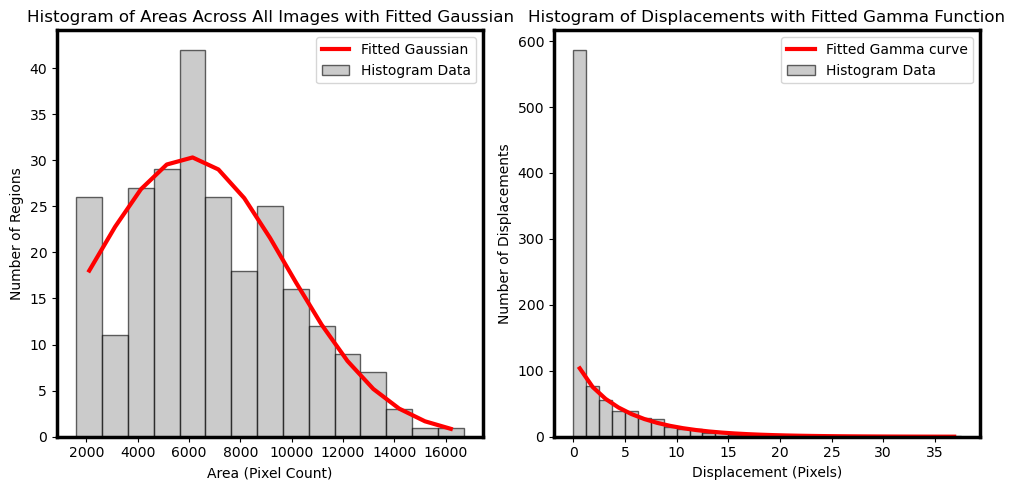

Statistics: mean_area:  6005.568662482415  sig_area:  3814.704096127828  gamma:k,theta,A_g  0.9213395891610326 5.373771605353078 555.8110410531892


NameError: name 'stop' is not defined

In [9]:
#print(stop)
path='/media/mo/KINGSTON/CTC_datasets/HUH/test'
name='MSC2'
save_path='/media/mo/KINGSTON/CTC_datasets_new/MSC2/'
mito_d=4



save_dir=save_path+name+'_train'

generate_CTC_datasets(path,name,save_dir,d=mito_d)

In [ ]:
def calculate_displacement(pos1, pos2):
    """Calculate 2D displacement between two positions."""
    return (np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2))*1024

def process_file(file_path):
    """Process a single pos_GT.txt file and return displacements."""
    data = np.loadtxt(file_path, skiprows=1)
    ids = np.unique(data[:, 3])
    displacements = []

    for id_val in ids:
        if id_val == -1:  # skip the -1 id
            continue
        # Get rows with the current id
        id_rows = data[data[:, 3] == id_val]
        # Sort rows by time
        id_rows = id_rows[np.argsort(id_rows[:, 6])]
        for i in range(1, len(id_rows)):
            pos1 = id_rows[i-1][:2]
            pos2 = id_rows[i][:2]
            displacements.append(calculate_displacement(pos1, pos2))
    return displacements

def process_folder(base_folder):
    """Process the entire folder structure and return all displacements."""
    all_displacements = []

    for root, dirs, files in os.walk(base_folder):
        if root.endswith('_GT'):
            file_path = os.path.join(root, 'TRA', 'pos_GT.txt')
            if os.path.exists(file_path):
                displacements = process_file(file_path)
                all_displacements.extend(displacements)
    return all_displacements

def plot_distance_histograms(distances_gen, distances_real_label_1, distances_real_label_0, save_path, gamma_params):
    # Create the plot
    plt.figure(figsize=(10, 7))
    
    # Define bins so that they align for both histograms
    bins = np.linspace(0, 20, 17)  # 16 bins between 0 and 20
    
    # Plot histograms individually to control labels
    sns.histplot(distances_gen[distances_gen <= 20], bins=bins, color="#2ecc71", label='Real Cell Displacements', kde=False)
    sns.histplot(distances_real_label_1[distances_real_label_1 <= 20], bins=bins, color="#3498db", label='Generated by Physics Model', kde=False)
    #sns.histplot(distances_real_label_0[distances_real_label_0 <= 20], bins=bins, color="#e74c3c", kde=False)
    
    # Generate and plot the gamma distribution
    x = np.linspace(0, 20, 500)
    plt.plot(x, gamma_distribution(x, *gamma_params), color="darkgreen", label='Fitted Gamma Distribution', linewidth=2)
    
    # Set plot aesthetic properties
    plt.title('Displacement Distribution', fontsize=20)
    plt.xlabel('Cell Displacement', fontsize=17.5)
    plt.ylabel('Frequency', fontsize=17.5)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=15, loc='upper right')
    sns.despine(left=True, bottom=True)  # Removes the top and right spines for a cleaner look
    plt.tick_params(labelsize=15)
    plt.tight_layout()
    plt.savefig(f"{save_path}/distance_distributions.png", dpi=300)
    plt.show()



In [ ]:
base_folder = '/media/mo/KINGSTON/Generated/HUH_back'


all_displacements = process_folder(base_folder)
real_displacements = np.load('all_displacements.npy')
print(len(all_displacements),len(real_displacements))


num_samples = len(real_displacements)
sampled_displacements = np.random.choice(all_displacements, num_samples, replace=False)
gamma_params=[1.4297845229972628,2.045733286663783,1515.8632380681279]
#sampled_displacements = all_displacements
plot_distance_histograms(real_displacements,sampled_displacements,[], ".",gamma_params)



#plt.hist(sampled_displacements, bins=50, color='blue', alpha=0.7)
#plt.hist(real_displacements, bins=50, color='red', alpha=0.7)
#plt.show()

#plt.hist(sampled_displacements, bins=50, color='blue', alpha=0.7)
#plt.show()
#plt.xlabel('Displacement (pixels)')
#plt.ylabel('Number of occurrences')
#plt.title('Histogram of Displacements')
#plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#plt.tight_layout()
#plt.show()
print(min(real_displacements), max(real_displacements))
print(min(sampled_displacements), max(sampled_displacements))